In [1]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import cv2
import numpy as np
from numba import njit
import os
import torch
from scipy.ndimage import zoom
import os

In [2]:
def get_closest_gray(value,gray_shades): 
    distances = np.abs(gray_shades - value)
    min_id = np.argmin(distances)
    return gray_shades[min_id]

def clamp_grayscale_image(arr,gray_shades):
    h, w = arr.shape
    simplified_arr = np.zeros((h, w), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            closest_shade = get_closest_gray(arr[i, j],gray_shades)
            simplified_arr[i, j] = closest_shade
    return simplified_arr

def simplify_grayscale_image(matrix, num_levels=4, remove_outlier_percentage = 0.1, unique = False):
    # Flatten the matrix to find min and max of the specified percentiles
    flattened = matrix.flatten()
    sorted_values = np.sort(flattened)
    if remove_outlier_percentage > 0:
        min_index = int(len(sorted_values) * remove_outlier_percentage)
        max_index = int(len(sorted_values) * (1-remove_outlier_percentage))
        sorted_values = sorted_values[min_index:max_index]
    if unique:
        sorted_values = np.unique(sorted_values)
    # this is done for certain images that have outlier pixels and that is annoying for the algorithm
    min_val = sorted_values[0]
    max_val = sorted_values[-1]
    gray_indices = np.linspace(0,len(sorted_values)-1,num_levels,dtype=int)
    grays = sorted_values[gray_indices]
    return clamp_grayscale_image(matrix,grays)

In [3]:
#This function gets an image and an index and apprends all the neigboring pixels
#To the index which contain the same value and creats a cluster
#it then returns the cluster
@njit
def propagate(matrix, index):
    bool_matrix = np.zeros(matrix.shape, dtype=np.int32)
    value = matrix[index]
    rows, cols = matrix.shape
    stack = [index]    
    directions = np.array([[-1, 0], [1, 0], [0, -1], [0, 1], [-1, -1], [-1, 1], [1, -1], [1, 1]])

    # Initialize bounding box corners
    top_left = (index[0], index[1])
    bottom_right = (index[0], index[1])

    while stack:
        current = stack.pop()
        row, col = current
        # Mark the current cell as part of the connected region
        bool_matrix[row, col] = 1
        
        # Update bounding box corners
        top_left = (min(top_left[0], row), min(top_left[1], col))
        bottom_right = (max(bottom_right[0], row), max(bottom_right[1], col))

        # Check all possible directions
        for d in range(directions.shape[0]):
            dr, dc = directions[d]
            new_row, new_col = row + dr, col + dc
            # Check if the new index is within bounds
            if 0 <= new_row < rows and 0 <= new_col < cols:
                # If the value matches and it's not already marked, add to stack
                if matrix[new_row, new_col] == value and bool_matrix[new_row, new_col] == 0:
                    stack.append((new_row, new_col))
    #stack = []
    return bool_matrix, top_left, bottom_right

In [4]:
def clean_dots(_matrix, region_size=8):
    matrix = _matrix.copy()
    h, w = matrix.shape
    half_region = region_size // 2
    padded_matrix = np.pad(matrix, pad_width=half_region, mode='constant', constant_values=0)
    
    for l in range(half_region, h + half_region):
        for k in range(half_region, w + half_region):
            top = l - half_region
            bottom = l + half_region + 1
            left = k - half_region
            right = k + half_region + 1
            submatrix = padded_matrix[top:bottom, left:right]
            p, tl, br = propagate(submatrix, (half_region, half_region))
            # Update the submatrix only if the region is not touching the padded borders
            if (tl[0] != 0) and (tl[1] != 0) and (br[0] != bottom - top - 1) and (br[1] != right - left - 1):
                padded_matrix[top:bottom, left:right][p != 0] = 0

    return padded_matrix[half_region:-half_region, half_region:-half_region]

In [5]:
def scale_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    # Avoid division by zero if the matrix has constant values
    if max_val - min_val == 0:
        return np.zeros(matrix.shape)
    # Scale the matrix between 0 and 1
    scaled_matrix = (matrix - min_val) / (max_val - min_val)
    return scaled_matrix

In [6]:
def reweight_image(matrix, k_neighbours=6):
    half_k = int(k_neighbours / 2)
    new_image = np.zeros_like(matrix)  # Create an output image with the same size as the input
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            # Define the bounds of the sub-region, ensuring we don't go out of bounds
            top = max(0, i - half_k)
            bottom = min(len(matrix), i + half_k + 1)
            left = max(0, j - half_k)
            right = min(len(matrix[0]), j + half_k + 1)
            # Extract the sub-region and compute the average
            sub_region = matrix[top:bottom, left:right]
            new_image[i, j] = np.average(sub_region)
    return new_image

In [7]:
def keep_highest(matrix):
    simplified = matrix * (matrix == np.max(matrix))
    return scale_matrix(simplified)

In [8]:
@njit
def return_continuous(array, pixel):
    result = []
    in_sequence = False  # Flag to track if we're currently in a sequence
    for index, value in enumerate(array):
        if value == pixel:
            if not in_sequence:  # Start of a new sequence
                result.append(index)
                in_sequence = True
        else:
            in_sequence = False  # End of the current sequence
    return result    

In [9]:
@njit
def pad_to_square(matrix):
    height, width = matrix.shape
    size = max(height, width)
    padded_matrix = np.zeros((size, size), dtype=matrix.dtype)
    start_height = (size - height) // 2
    start_width = (size - width) // 2
    padded_matrix[start_height:start_height+height, start_width:start_width+width] = matrix
    return padded_matrix

In [10]:
def threshold_matrix(matrix,threshold,ignore_zeros = False):
    # Flatten the matrix to find min and max of the specified percentiles
    flattened = matrix.flatten()
    sorted_values = np.sort(flattened)
    if ignore_zeros:
        sorted_values = sorted_values[sorted_values>0]
    threshold_index = int(len(sorted_values) * threshold)
    return (matrix * (matrix > sorted_values[threshold_index]))

In [11]:
@njit
def extract_images(simplified_image,min_area,max_area,min_len = 4, h = 25):
    image_area = simplified_image.shape[0] * simplified_image.shape[1]
    min_area = image_area * min_area
    max_area = image_area * max_area
    middle_strip = simplified_image[h, :]
    pixel = np.max(simplified_image)
    continuous = return_continuous(middle_strip, pixel)
    images_list = []
    images_top_left = []
    images_bottom_right = []
    for v in continuous:
        im, tl, br = propagate(simplified_image, (h, v))
        #clusters.append(im.copy())
        im_area = (br[0]-tl[0]) * (br[1]-tl[1])
        im = im[tl[0]:br[0], tl[1]:br[1]]
        im = pad_to_square(im)
        if min_area < im_area < max_area and tl not in images_top_left:
            images_list.append(im)
            images_top_left.append(tl)
            images_bottom_right.append(br)
    return images_list,images_top_left,images_bottom_right

In [12]:
def pipeline(matrix):
    out = matrix.copy()
    out = simplify_grayscale_image(matrix,num_levels=10)
    out = clean_dots(out,region_size=10)
    out = reweight_image(out,k_neighbours=3)
    out = threshold_matrix(out,0.2,ignore_zeros = True)
    out = simplify_grayscale_image(out,4,unique=True)
    out = keep_highest(out)
    out = clean_dots(out,region_size=10)
    return out

In [18]:
#This is used to load the model I use from another jupyter notebook in the same directory
import nbimporter 
from EMNIST_CNN import CNN
device = torch.device('cuda')
cnn = CNN().to(device)
cnn.eval()
cnn.load_state_dict(torch.load('./EMNIST_MODEL.pth',weights_only=True))

<All keys matched successfully>

In [19]:
# Create the character to number dictionary
char_to_num = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18,
    'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27,
    'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35
}
# Create the number to character dictionary by inverting char_to_num
num_to_char = {v: k for k, v in char_to_num.items()}

In [20]:
def one_hot_decode(one_hot_vector):
    index = np.argmax(one_hot_vector)
    return index

In [21]:
def resize_image_to_target(image, target_size=(28, 28)):
    original_height, original_width = image.shape[:2]
    zoom_factors = (target_size[0] / original_height, target_size[1] / original_width)
    resized_image = zoom(image, zoom_factors, order=3)  # Using cubic interpolation
    return resized_image

In [22]:
def predict_character(image):
    image = resize_image_to_target(image)
    x = torch.Tensor(image).to(device).unsqueeze(0).unsqueeze(0)
    pred = cnn(x)
    pred = pred.cpu().detach().numpy() 
    pred = one_hot_decode(pred[0]) 
    pred = num_to_char[pred]
    return pred

In [23]:
def display_images(gray_image,processed_image,individual_images):
        # Create a figure with 3 columns
        fig = plt.figure(figsize=(15, 4))  # Reduced height from 5 to 4
        
        # Create a 1x3 grid
        gs = fig.add_gridspec(1, 3)
        
        # Display the original grayscale image in the first column
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.imshow(gray_image, cmap='gray')
        ax1.set_title('Original')
        ax1.axis('off')
        
        # Display the processed image in the second column
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.imshow(processed_image, cmap='gray')
        ax2.set_title('Processed')
        ax2.axis('off')
        
        # Create a subplot for the third column
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.axis('off')
        ax3.set_title('extracted letters and their prediction')
        
        # Divide the third column equally for individual images
        num_individual = len(individual_images)
        if num_individual > 0:
            individual_gs = gs[0, 2].subgridspec(1, num_individual, wspace=0.1, hspace=0.1)
            for i, extracted_image in enumerate(individual_images):
                ax_sub = fig.add_subplot(individual_gs[0, i])
                extracted_image = np.pad(extracted_image, pad_width=5, mode='constant', constant_values=0)
                pred = predict_character(extracted_image)
                ax_sub.imshow(pad_to_square(extracted_image), cmap='gray')
                ax_sub.set_title(f'{pred}')
                ax_sub.axis('off')
        
        # Adjust layout to reduce vertical spacing
        plt.subplots_adjust(top=0.4, bottom=0.1, hspace=0.2)
        
        # Show the figure
        plt.show()
    

In [24]:
def process_images(directory, pipeline, amount=np.inf):
    # List all files in the directory
    image_files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if amount != np.inf:
        image_files = np.random.choice(image_files,amount)
    counter = 0
    for image_file in image_files:
        image_path = os.path.join(directory, image_file)
        
        # Read and preprocess the image
        img = imageio.imread(image_path)
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255
        gray_image = 1 - gray_image
        
        # Apply the pipeline to the gray image
        processed_image = pipeline(gray_image)
        individual_images, tl_list, br_list = extract_images(processed_image, min_area=0.02, max_area=0.9)
        
        #If our pipeline failed to find the 5 images I skip it :( but if you play with
        #The code you can ensure that it will always find 5 images, good luck writing this code
        #For now I skipped it but one day it will be fixed :)
        #Currently it works 90% of the times anywas
        if len(individual_images) != 5:
            continue  

        display_images(gray_image,processed_image,individual_images)
        
        counter += 1
        if counter >= amount:
            break

    print(f"Processed {counter} images")

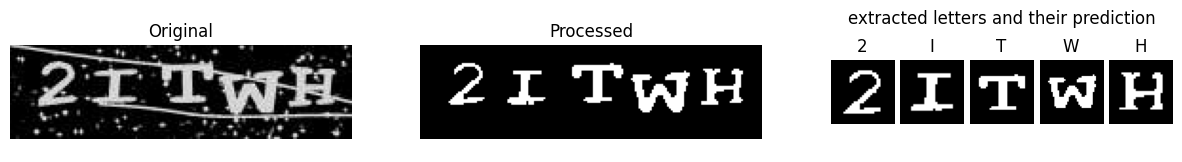

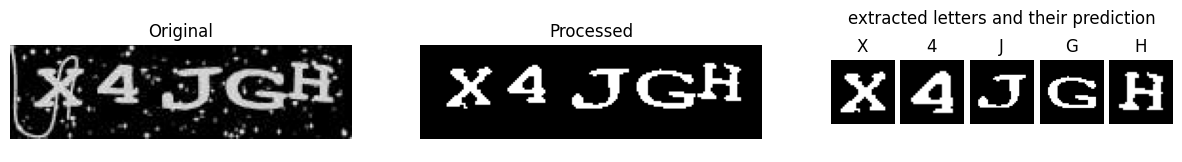

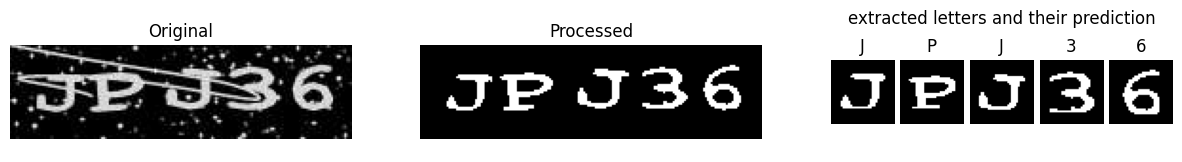

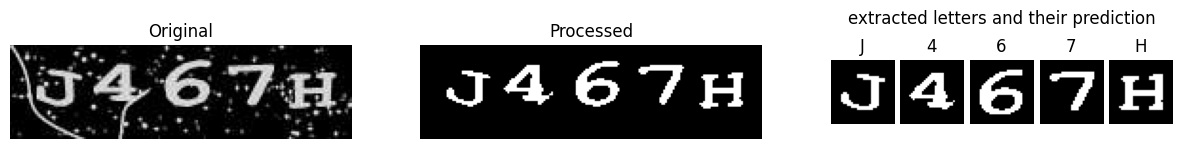

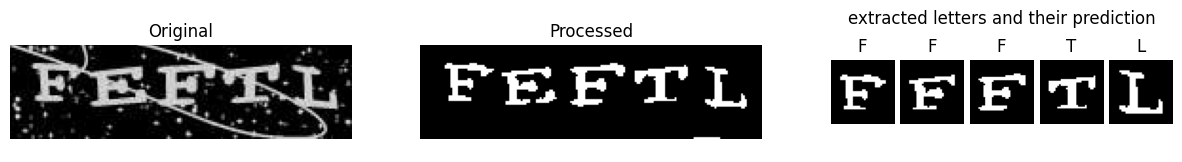

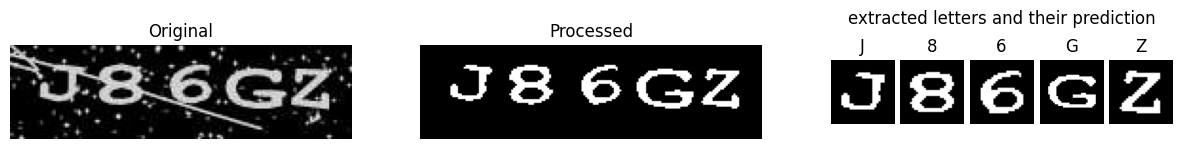

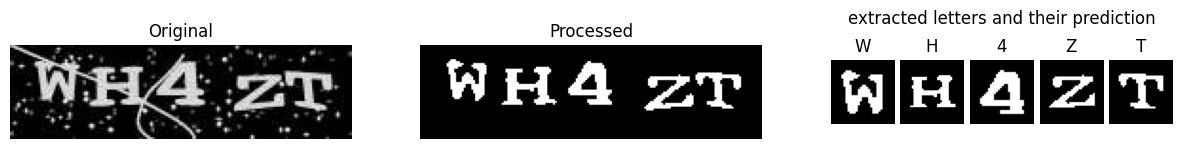

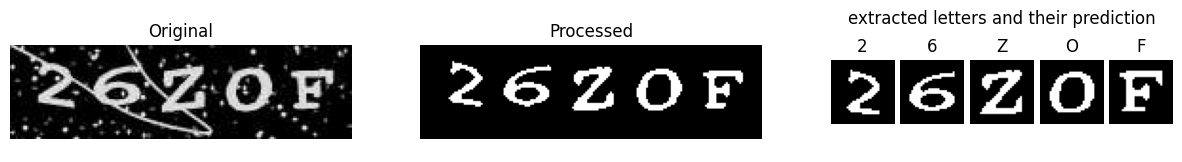

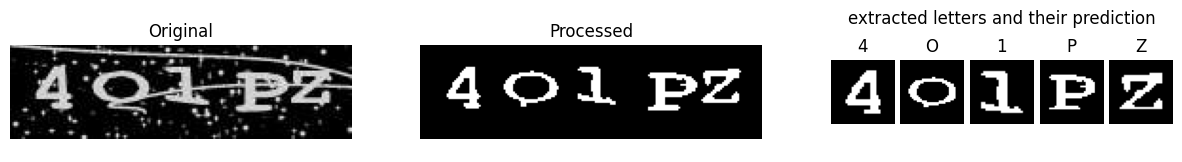

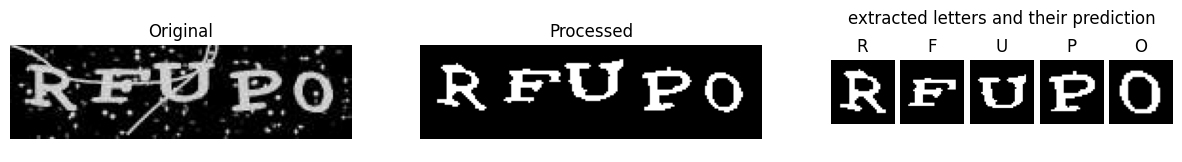

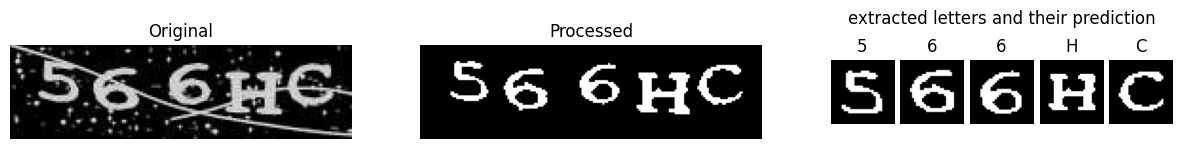

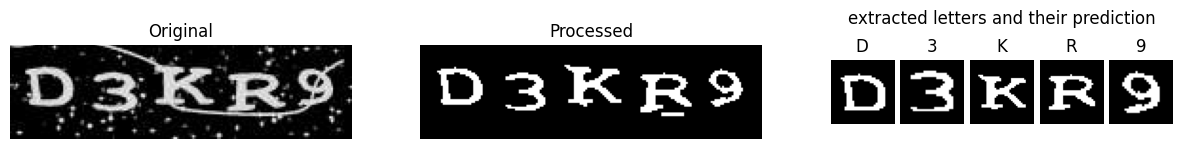

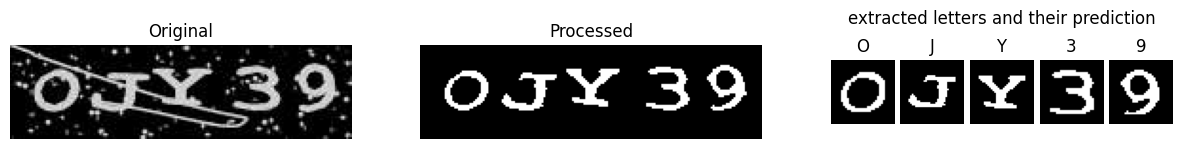

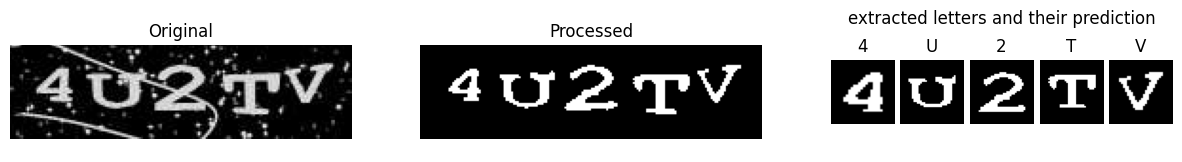

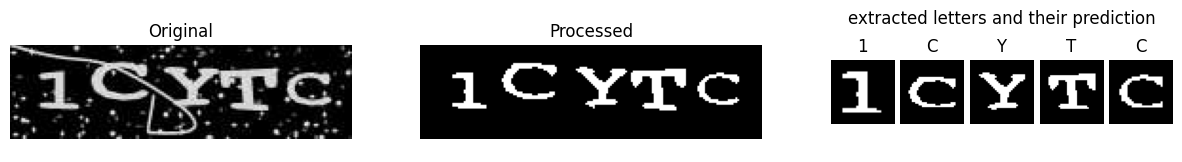

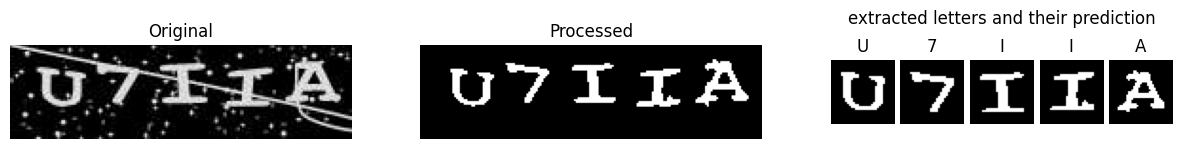

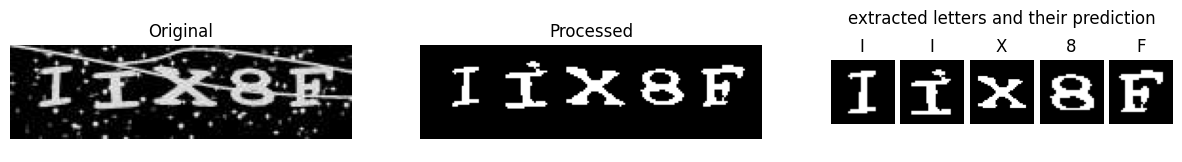

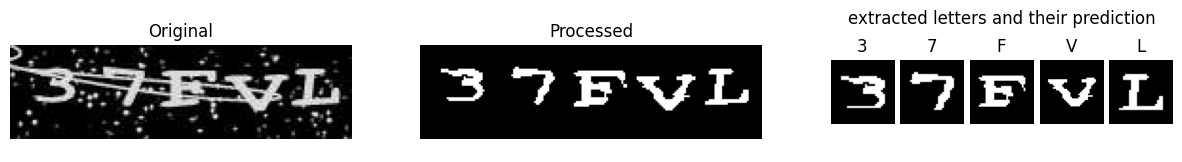

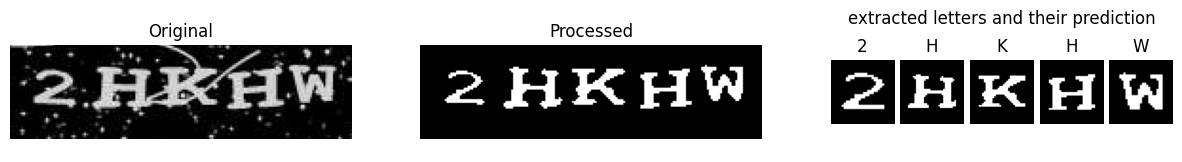

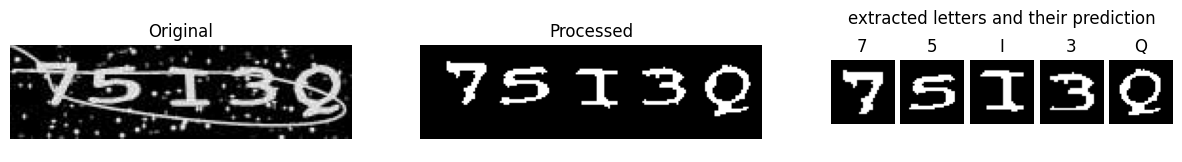

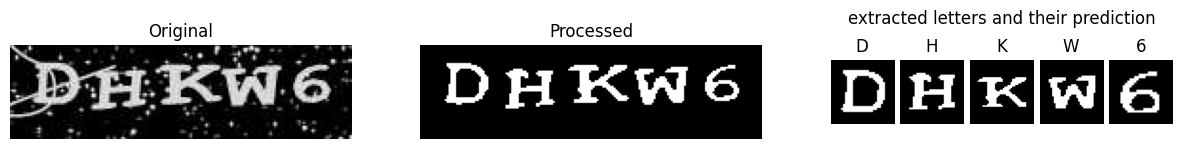

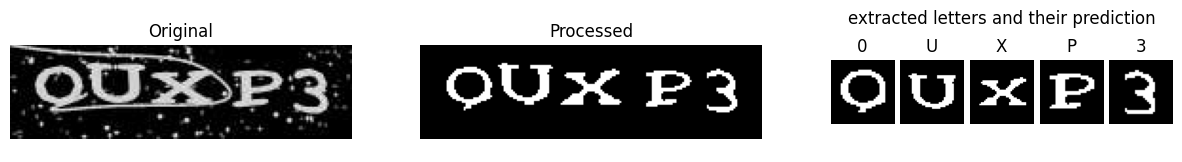

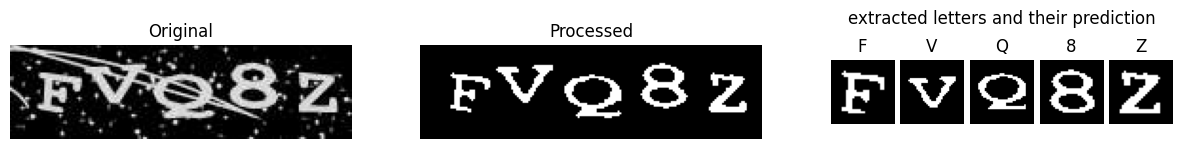

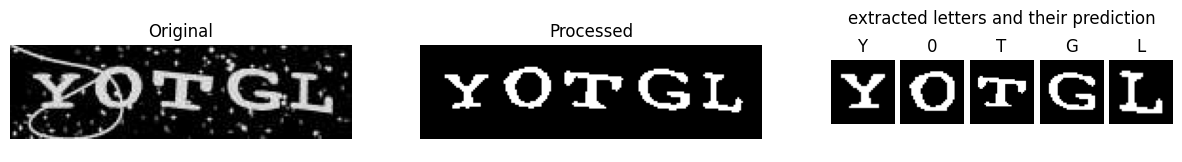

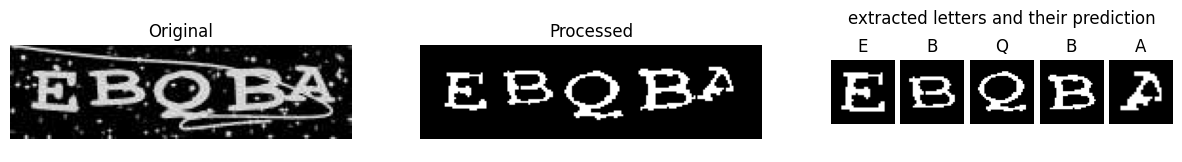

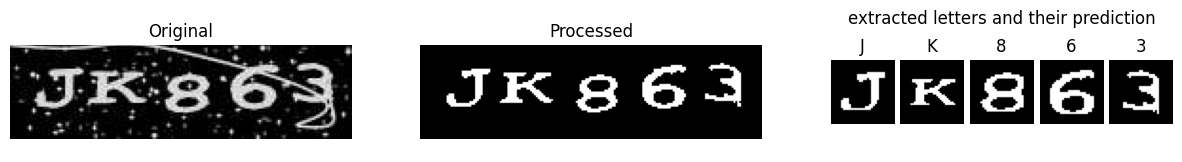

Processed 26 images


In [25]:
# Example usage
directory = "C://Users//skche//Downloads//captcha//teltest2"
process_images(directory, pipeline,30)